# RPM tumor time series analysis

In [2]:
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "/Users/geenaildefonso/Projects/")
import mazebox as mb

In [3]:
adata = scv.read('/Users/geenaildefonso/Dropbox (VU Basic Sciences)/RPM/adata05.h5ad')

In [ ]:
adata = scv.read('RPM_adata_dynamicalmodeling_7548genes.h5ad')

In [3]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

In [ ]:
indir = "/Users/geenaildefonso/Dropbox (VU Basic Sciences)/loom/RPM"

samples = ['SRR11594440','SRR11594441','SRR11594442','SRR11594443','SRR11594444','SRR11594445','SRR11594446']
[a1,a2,a3,a4,a5,a6,a7] = [mb.pp.read_loom(sample, indir) for sample in samples]


In [4]:
tfs = ['SP100', 'FOSL1', 'HES1', 'NFKBIZ', 'RELB', 'EPAS1', 'BCL3', 'REST', 'SP110', 'NFKB2', 'TEAD2', 'HMG20B', 'SIX5',
       'RARG', 'TEAD4', 'ZNF217', 'SP140L', 'SOX18', 'HOXC13', 'STAT6', 'ETV4', 'KLF2', 'MITF', 'NR0B2', 'ASCL1', 'ZBTB7C', 'ELF3',
       'RORC', 'FOXA2', 'ETS2','TOX3', 'XBP1', 'ST18', 'FOXA1', 'OVOL2', 'ZNF664', 'TBX10', 'PROX1', 'ETV6', 'CEBPD', 'TFCP2L1', 'FOXJ3',
       'ZNF407', 'ZNF511','ZNF396', 'RBPJ', 'ZSCAN31', 'HOXB5', 'ZNF3', 'TSHZ2', 'ZBTB16', 'ZNF10', 'FLI1', 'GATA4', 'NR0B1', 'NHLH1',
       'NEUROD6', 'ZNF581', 'TCF15', 'LYAR', 'ISL2', 'OLIG2', 'NEUROD1', 'INSM1', 'PAX5', 'SP6', 'MYT1', 'HES6', 'ZNF24', 'ISL1', 'ZNF397',
       'SOX11', 'ZNF253', 'SMAD4', 'RBP1', 'ONECUT2', 'ZNF711', 'DLX5', 'GRIP1', 'ZNF157', 'ZNF713', 'ZNF136', 'FOXN4', 'PATZ1', 'ZNF491',
       'ZBTB21', 'KLF12', 'ZNF501', 'ZNF785', 'CXXC1', 'ZNF324', 'ZNF764', 'ZBTB18', 'KAT8', 'ZNF334', 'POU4F1', 'ZNF250', 'ZNF132',
       'SALL2', 'DLX6', 'MBD1','SOX1', 'ZFP3', 'ZNF543', 'POU2F1', 'NONO', 'SMAD9', 'ZKSCAN2', 'TCF12', 'VEZF1', 'TOX', 'BHLHE22', 'MTA1',
       'TCF3', 'SCRT2', 'RFX7','NHLH2', 'SCRT1', 'RCOR2', 'PURG', 'TBPL1', 'TCF4', 'EBF1', 'ZNF749', 'NEUROD2', 'ZNF423', 'BACH2', 'GLI1',
       'ZFP64','NKX2-1', 'MYC', 'YAP1', 'POU2F3', 'MYCL', 'MYCN', 'ASCL2', 'AVIL', 'CHAT', 'GFI1B',
      'CHGA','EPCAM']

In [ ]:
#DOES NOT WORK FOR GEENA :(
batch_categories = ['day_4','day_7','day_11','day_14','day_17','day_21']
batch_key = 'timepoint'

a1 = a1.concatenate(a2) #concatenate both day_4 datasets into one
adatas = [a1,a3,a4,a5,a6,a7] #a2 is already merged with a1

adata = mb.pp.dropkick_recipe(adatas, verbose=False, batch_categories = batch_categories, batch_key = batch_key,
                                                X_final = 'log1p_norm',plot = False,
                                                retain_genes=[i.capitalize() for i in tfs])

In [ ]:
filterd = mb.pp.scanpy_recipe(adata, retain_genes=tfs)

In [ ]:
adata_check = adata_full.copy()

In [ ]:
adata_check.X.todense()

In [ ]:
mb.pp.scanorama_recipe(adata, groups = 'cline', correct = True, basis = 'umap')

In [ ]:
import matplotlib.pyplot as plt
# sc.pp.neighbors(adata)
# sc.tl.leiden(adata)
# sc.tl.umap(adata, random_state = 1)
sc.pl.umap(adata, color = ['timepoint','leiden','Ascl1','Myc','Epcam','Hes1'], ncols = 3)

# Dynamical Modeling scVelo

## Prepare the data!

Processing consists of gene selection, normalizing by total size, logarithmizing X, and computing moments for velocity estimation. See the previous tutorial for further explanation.

In [121]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=7548, retain_genes = tfs)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 10170 genes that are detected 20 counts (shared).
Extracted 8688 highly variable genes.
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Dynamical Model

We run the dynamical model to learn the full transcriptional dynamics of splicing kinetics.

It is solved in a likelihood-based expectation-maximization framework, by iteratively estimating the parameters of reaction rates and latent cell-specific variables, i.e. transcriptional state and cell-internal latent time. It thereby aims to learn the unspliced/spliced phase trajectory for each gene.

Running the dynamical model can take a while. Hence, you may want to store the results for re-use, with adata.write('data/pancreas.h5ad', which can later be read with adata = scv.read('data/pancreas.h5ad').

In [122]:
scv.tl.recover_dynamics(adata) #change max_iter more than 10? 

recovering dynamics (using 1/16 cores)


  0%|          | 0/854 [00:00<?, ?gene/s]

    finished (0:22:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [123]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:20) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/15257 [00:00<?, ?cells/s]

    finished (0:00:56) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
adata.write('RPM_adata_dynamicalmodeling_7548genes.h5ad', compression='gzip')

In [ ]:
adata.write('RPM_adata_dynamicalmodeling.h5ad', compression='gzip')

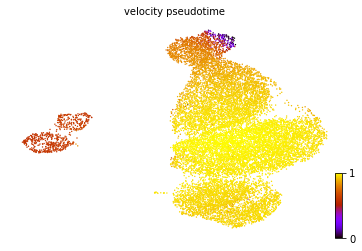

In [124]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', color_map='gnuplot')

computing velocity embedding
    finished (0:00:05) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


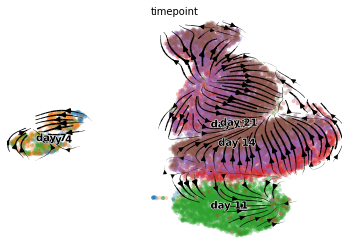

In [8]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['timepoint'])

In [11]:
myc_genes = ['Srsf2', 'G3bp1', 'Snrpd1', 'Pgk1', 'Rps3', 'Psmd1', 'Orc2', 'Psma2', 'Syncrip', 'Cnbp',
            'Gspt1', 'Ppm1g', 'Eif4e', 'Hnrnpa3', 'Abce1', 'Hnrnpu',  'Ifrd1', 'Kpna2', 'Dhx15', 'Mcm4']

In [13]:
scv.pl.heatmap(adata, var_names = myc_genes)

KeyError: 'latent_time'

ValueError: color key is invalid! pass valid observation annotation or a gene name

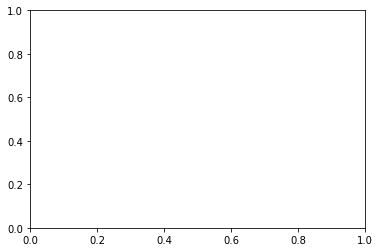

In [120]:
scv.pl.velocity_embedding(adata, basis='umap',color=['latent_time'])

saving figure to file ./figures/scvelo_vel_embedded_stream.pdf


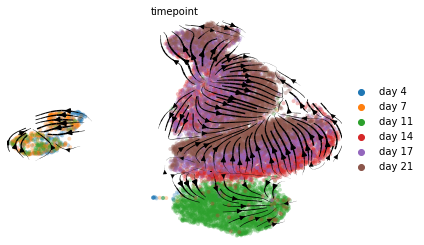

In [69]:
# plt.figure()
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['timepoint'], legend_loc = 'on right',
                                 save = 'vel_embedded_stream.pdf')
# plt.savefig('velocity_embedding_stream_timepoint.pdf')

ValueError: color key is invalid! pass valid observation annotation or a gene name

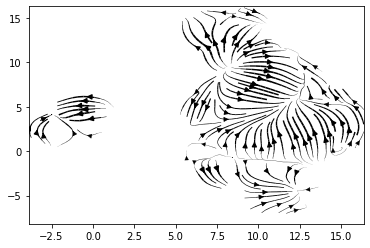

In [119]:
# plt.figure()
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['latent_time'], legend_loc = 'on right')

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
saving figure to file ./figures/scvelo_velocity_confidence.pdf


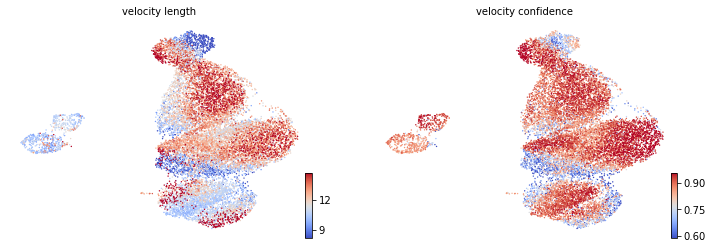

In [58]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95] ,save = 'velocity_confidence.pdf')

In [68]:
df = adata.obs.groupby('timepoint')[keys].mean().T

# plt.figure()
df.style.background_gradient(cmap='coolwarm', axis=1)

# plot.savefig('vel_length_confidence_chart.pdf', format = 'pdf')
                          
# plt.savefig('vel_length_confidence_chart.pdf')

# Kinetic Rate Parameters

The rates of RNA transcription, splicing and degradation are estimated without the need of any experimental data.

They can be useful to better understand the cell identity and phenotypic heterogeneity.


The estimated gene-specific parameters comprise rates of transription (fit_alpha), splicing (fit_beta), degradation (fit_gamma), switching time point (fit_t_), a scaling parameter to adjust for under-represented unspliced reads (fit_scaling), standard deviation of unspliced and spliced reads (fit_std_u, fit_std_s), the gene likelihood (fit_likelihood), inferred steady-state levels (fit_steady_u, fit_steady_s) with their corresponding p-values (fit_pval_steady_u, fit_pval_steady_s), the overall model variance (fit_variance), and a scaling factor to align the gene-wise latent times to a universal, gene-shared latent time (fit_alignment_scaling).

In [125]:
df_rpmg = adata.var

In [126]:
df_rpmg = scv.get_df(adata, 'fit*', dropna=True) # had to run this first to get fit_alpha etc. to show
df_rpmg

fit_alpha  fit_beta  fit_gamma  fit_t_  fit_scaling  fit_std_u  \
Malat1        40.87  5.79e-01       0.40   11.38     3.10e-01   1.44e+01   
Ctsl           9.88  2.23e+01       0.96   15.33     2.21e-02   1.26e-01   
Hnrnpu         5.11  2.11e+00       0.39   12.97     1.08e-01   5.80e-01   
G3bp1          4.84  3.21e+00       0.35   13.50     5.72e-02   2.77e-01   
Anxa2         10.70  7.05e+00       0.63    7.09     4.65e-02   3.88e-01   
...             ...       ...        ...     ...          ...        ...   
Dgki           0.01  7.24e-03       0.06   61.31     1.27e+01   3.76e-01   
Stfa3          6.76  3.96e+02       8.05    2.74     7.63e-03   3.74e-03   
Erbb4          0.02  7.98e-03       0.14   16.59     2.85e+01   9.00e-01   
Spock1         0.01  1.21e-02       0.11  127.55     2.38e+01   3.88e-01   
Cntnap5b       0.02  8.34e-03       0.06    9.64     2.10e+01   9.27e-01   

          fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
Malat1        21.94        2.35e-01     0.0     0.0         4.99e-01   
Ctsl           2.70        2.45e-01     0.0     0.0         4.91e-01   
Hnrnpu         2.53        2.32e-01     0.0     0.0         4.72e-01   
G3bp1          2.29        2.62e-01     0.0     0.0         4.68e-01   
Anxa2          3.95        3.13e-01     0.0     0.0         4.84e-01   
...             ...             ...     ...     ...              ...   
Dgki           0.03        2.14e-27     0.0     0.0         8.57e-02   
Stfa3          0.22        6.01e-82     0.0     0.0         4.10e-01   
Erbb4          0.03        1.26e-06     0.0     0.0         1.83e-01   
Spock1         0.03        5.09e-13     0.0     0.0         1.83e-05   
Cntnap5b       0.06        4.14e-26     0.0     0.0         2.10e-01   

          fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
Malat1           66.13         93.34          0.97                   2.51   
Ctsl              0.44         10.53          0.93                   0.96   
Hnrnpu            2.03         10.52          0.96                   1.97   
G3bp1             1.01          9.31          0.84                   2.46   
Anxa2             1.22         11.99          0.54                   1.37   
...                ...           ...           ...                    ...   
Dgki              1.15          0.09          0.53                  12.73   
Stfa3             0.02          0.93          0.03                   0.15   
Erbb4             2.39          0.10          1.39                   4.25   
Spock1            0.85          0.07          0.56                   4.36   
Cntnap5b          1.94          0.16          0.31                   8.84   

          fit_r2  
Malat1      0.64  
Ctsl        0.43  
Hnrnpu      0.24  
G3bp1       0.35  
Anxa2       0.46  
...          ...  
Dgki        0.74  
Stfa3       0.15  
Erbb4       0.79  
Spock1      0.74  
Cntnap5b    0.43  

[1309 rows x 16 columns]

In [25]:
df_rpmg['fit_likelihood']

Malat1     2.352324e-01
Bsg        2.410296e-01
Rps3       2.199197e-01
Cnbp       2.684792e-01
Ctsl       2.454224e-01
               ...     
Mybpc1     5.585646e-07
Gm10639    1.045320e-05
Gm33843    2.928054e-03
Ptgdr      1.200078e-74
Olfm3      3.407897e-05
Name: fit_likelihood, Length: 2709, dtype: float64

In [61]:
dfnew = df_rpmg['fit_likelihood']
data['Name'] = data['Name'].str.upper()

Malat1     2.352324e-01
Bsg        2.410296e-01
Rps3       2.199197e-01
Cnbp       2.684792e-01
Ctsl       2.454224e-01
               ...     
Mybpc1     5.585646e-07
Gm10639    1.045320e-05
Gm33843    2.928054e-03
Ptgdr      1.200078e-74
Olfm3      3.407897e-05
Name: fit_likelihood, Length: 2709, dtype: float64

In [11]:
df_rpmg.to_pickle('rpm_tumors_fitlikedf.pkl')

In [62]:
dfnew.to_csv('rpm_FL_noheader.csv', header=None, sep='\t')

In [84]:
df = pd.read_csv('rpm_FL_noheader.csv', header=None, sep='\t', names = ['genes', 'fit_likelihood'])

In [85]:
df

genes  fit_likelihood
0      Malat1    2.352324e-01
1         Bsg    2.410296e-01
2        Rps3    2.199197e-01
3        Cnbp    2.684792e-01
4        Ctsl    2.454224e-01
...       ...             ...
2704   Mybpc1    5.585646e-07
2705  Gm10639    1.045320e-05
2706  Gm33843    2.928054e-03
2707    Ptgdr    1.200078e-74
2708    Olfm3    3.407897e-05

[2709 rows x 2 columns]

In [86]:
df['genes'] = df['genes'].str.upper()

In [87]:
df

genes  fit_likelihood
0      MALAT1    2.352324e-01
1         BSG    2.410296e-01
2        RPS3    2.199197e-01
3        CNBP    2.684792e-01
4        CTSL    2.454224e-01
...       ...             ...
2704   MYBPC1    5.585646e-07
2705  GM10639    1.045320e-05
2706  GM33843    2.928054e-03
2707    PTGDR    1.200078e-74
2708    OLFM3    3.407897e-05

[2709 rows x 2 columns]

In [95]:
df.index = df.genes
df

genes  fit_likelihood
genes                           
MALAT1    MALAT1    2.352324e-01
BSG          BSG    2.410296e-01
RPS3        RPS3    2.199197e-01
CNBP        CNBP    2.684792e-01
CTSL        CTSL    2.454224e-01
...          ...             ...
MYBPC1    MYBPC1    5.585646e-07
GM10639  GM10639    1.045320e-05
GM33843  GM33843    2.928054e-03
PTGDR      PTGDR    1.200078e-74
OLFM3      OLFM3    3.407897e-05

[2709 rows x 2 columns]

In [96]:
df.drop(columns = ['genes'])

fit_likelihood
genes                  
MALAT1     2.352324e-01
BSG        2.410296e-01
RPS3       2.199197e-01
CNBP       2.684792e-01
CTSL       2.454224e-01
...                 ...
MYBPC1     5.585646e-07
GM10639    1.045320e-05
GM33843    2.928054e-03
PTGDR      1.200078e-74
OLFM3      3.407897e-05

[2709 rows x 1 columns]

In [100]:
df.index.name = None
df

genes  fit_likelihood
MALAT1    MALAT1    2.352324e-01
BSG          BSG    2.410296e-01
RPS3        RPS3    2.199197e-01
CNBP        CNBP    2.684792e-01
CTSL        CTSL    2.454224e-01
...          ...             ...
MYBPC1    MYBPC1    5.585646e-07
GM10639  GM10639    1.045320e-05
GM33843  GM33843    2.928054e-03
PTGDR      PTGDR    1.200078e-74
OLFM3      OLFM3    3.407897e-05

[2709 rows x 2 columns]

In [101]:
df = df.iloc[: , 1:]
df

fit_likelihood
MALAT1     2.352324e-01
BSG        2.410296e-01
RPS3       2.199197e-01
CNBP       2.684792e-01
CTSL       2.454224e-01
...                 ...
MYBPC1     5.585646e-07
GM10639    1.045320e-05
GM33843    2.928054e-03
PTGDR      1.200078e-74
OLFM3      3.407897e-05

[2709 rows x 1 columns]

In [122]:
df.drop(columns = ['fit_likelihood'])
df

fit_likelihood
MALAT1     2.352324e-01
BSG        2.410296e-01
RPS3       2.199197e-01
CNBP       2.684792e-01
CTSL       2.454224e-01
...                 ...
MYBPC1     5.585646e-07
GM10639    1.045320e-05
GM33843    2.928054e-03
PTGDR      1.200078e-74
OLFM3      3.407897e-05

[2709 rows x 1 columns]

In [114]:
df3 = df[:].values
df3

array([[2.35232398e-01],
       [2.41029584e-01],
       [2.19919682e-01],
       ...,
       [2.92805361e-03],
       [1.20007821e-74],
       [3.40789663e-05]])

In [99]:
df.drop(columns = ['genes'])
df

genes  fit_likelihood
MALAT1    MALAT1    2.352324e-01
BSG          BSG    2.410296e-01
RPS3        RPS3    2.199197e-01
CNBP        CNBP    2.684792e-01
CTSL        CTSL    2.454224e-01
...          ...             ...
MYBPC1    MYBPC1    5.585646e-07
GM10639  GM10639    1.045320e-05
GM33843  GM33843    2.928054e-03
PTGDR      PTGDR    1.200078e-74
OLFM3      OLFM3    3.407897e-05

[2709 rows x 2 columns]

In [ ]:
df_final = print(df.to_string(header=False))

In [117]:
df.to_csv('rpm_FL_noheader_caps.csv', header=None, sep='\t')

In [116]:
df

fit_likelihood
MALAT1     2.352324e-01
BSG        2.410296e-01
RPS3       2.199197e-01
CNBP       2.684792e-01
CTSL       2.454224e-01
...                 ...
MYBPC1     5.585646e-07
GM10639    1.045320e-05
GM33843    2.928054e-03
PTGDR      1.200078e-74
OLFM3      3.407897e-05

[2709 rows x 1 columns]

In [119]:
df2 = pd.read_csv('rpm_FL_noheader_caps.csv', header=None)

In [121]:
df2

0
0          MALAT1\t0.2352323982502608
1             BSG\t0.2410295838988631
2            RPS3\t0.2199196817995783
3            CNBP\t0.2684791620862677
4            CTSL\t0.2454224444413248
...                               ...
2704    MYBPC1\t5.585646454860335e-07
2705  GM10639\t1.0453198831817962e-05
2706      GM33843\t0.0029280536057395
2707    PTGDR\t1.2000782061881229e-74
2708     OLFM3\t3.407896625852693e-05

[2709 rows x 1 columns]

In [105]:
df2

0             1
0      MALAT1  2.352324e-01
1         BSG  2.410296e-01
2        RPS3  2.199197e-01
3        CNBP  2.684792e-01
4        CTSL  2.454224e-01
...       ...           ...
2704   MYBPC1  5.585646e-07
2705  GM10639  1.045320e-05
2706  GM33843  2.928054e-03
2707    PTGDR  1.200078e-74
2708    OLFM3  3.407897e-05

[2709 rows x 2 columns]

In [64]:
df

0             1
0      Malat1  2.352324e-01
1         Bsg  2.410296e-01
2        Rps3  2.199197e-01
3        Cnbp  2.684792e-01
4        Ctsl  2.454224e-01
...       ...           ...
2704   Mybpc1  5.585646e-07
2705  Gm10639  1.045320e-05
2706  Gm33843  2.928054e-03
2707    Ptgdr  1.200078e-74
2708    Olfm3  3.407897e-05

[2709 rows x 2 columns]

<AxesSubplot:xlabel='transcription rate', ylabel='Frequency'>

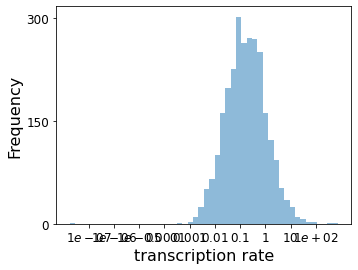

In [49]:
kwargs = dict(xscale='log', fontsize=16, figsize = (5,15))
# with scv.GridSpec(ncols=3) as pl:
pl.hist(df_rpmg['fit_alpha'], xlabel='transcription rate', ylabel = 'Frequency', 
**kwargs)
    # pl.hist(df_rpmg['fit_beta'] * df_rpmg['fit_scaling'], xlabel='splicing rate', **kwargs)
    # pl.hist(df_rpmg['fit_gamma'], xlabel='degradation rate', **kwargs)

<AxesSubplot:xlabel='splicing rate'>

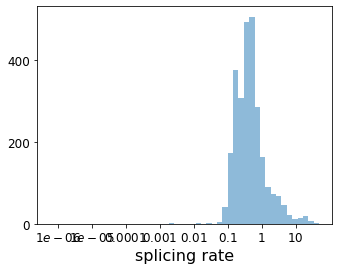

In [42]:
kwargs = dict(xscale='log', fontsize=16, figsize = (5,15))
# with scv.GridSpec(ncols=3) as pl:
pl.hist(df_rpmg['fit_beta'] * df_rpmg['fit_scaling'], xlabel='splicing rate', **kwargs)

# kwargs = dict(xscale='log', fontsize=16)
# with scv.GridSpec(ncols=3) as pl:
#     pl.hist(df_rpmg['fit_alpha'], xlabel='transcription rate', **kwargs)
#     pl.hist(df_rpmg['fit_beta'] * df_rpmg['fit_scaling'], xlabel='splicing rate', **kwargs)
#     pl.hist(df_rpmg['fit_gamma'], xlabel='degradation rate', **kwargs)

<AxesSubplot:xlabel='degradation rate'>

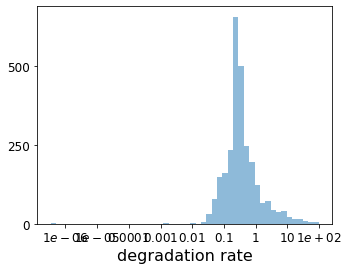

In [45]:
kwargs = dict(xscale='log', fontsize=16, figsize = (5,15))
# with scv.GridSpec(ncols=3) as pl:
pl.hist(df_rpmg['fit_gamma'], xlabel='degradation rate', **kwargs)

# Latent Time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

computing latent time using root_cells as prior
    finished (0:00:47) --> added 
    'latent_time', shared time (adata.obs)


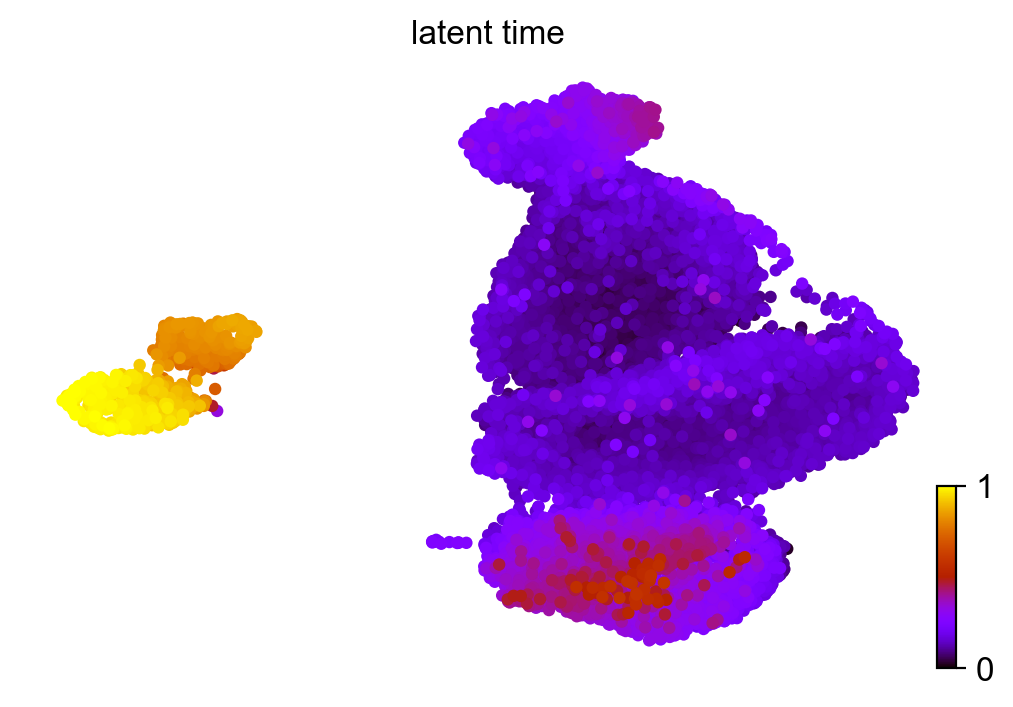

In [16]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

computing latent time using root_cells as prior
    finished (0:00:13) --> added 
    'latent_time', shared time (adata.obs)


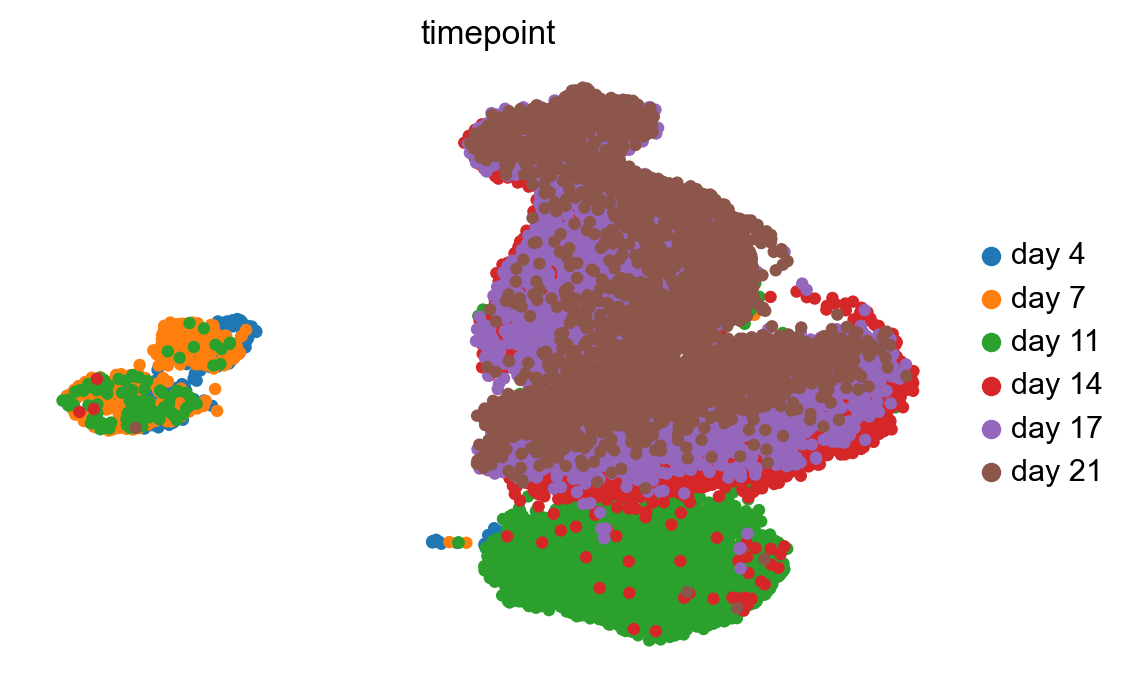

In [43]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='timepoint', color_map='gnuplot', size=80, legend_loc = 'onright')

In [53]:
adata.var['fit_likelihood'].max()

0.5217815149297748

In [127]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]

In [72]:
top_genes

Index(['Shisa2', 'Shtn1', 'Top2a', 'Smc4', 'Cadps2', 'Scg3', 'Wnk2', 'Bspry',
       'Epcam', 'Aldh1a7',
       ...
       'Nop58', 'Wtip', 'Pcolce', 'Mtrex', 'Cdc25b', 'Mxra7', 'St8sia5',
       'Exo1', 'Spag5', 'Snap91'],
      dtype='object', length=300)

In [130]:
adata

AnnData object with n_obs × n_vars = 15257 × 8688
    obs: 'Clusters', '_X', '_Y', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'batch', 'timepoint', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'barcode', 'kept', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'dpt_pseudotime', 'col', 'absorbing', 'absorb_group', 'log1p_plasticity', 'SCLC-Y_Score', 'SCLC-Y_Col', 'SCLC-P_Score', 'SCLC-P_Col', 'SCLC-N_Score', 'SCLC-N_Col', 'SCLC-A2_Score', 'SCLC-A2_Col', 'SCLC-A_Score', 'SCLC-A_Col', 'Phenotype_unfiltered', 'max', 'SCLC-Yscore', 'SCLC-Ycol

In [128]:
scv.pl.heatmap(adata, var_names=top_genes, sortby='timepoint', col_color='timepoint', n_convolve=100)

TypeError: Object with dtype category cannot perform the numpy op isfinite

In [129]:
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

KeyError: 'latent_time'

In [118]:
# top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='timepoint', col_color = 'timepoint',n_convolve=100)

TypeError: Object with dtype category cannot perform the numpy op isfinite

In [76]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='timepoint')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:04) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [117]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='timepoint')
df = scv.get_df(adata, 'paga/connectivities', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_scv_paga_umap_transitions.pdf


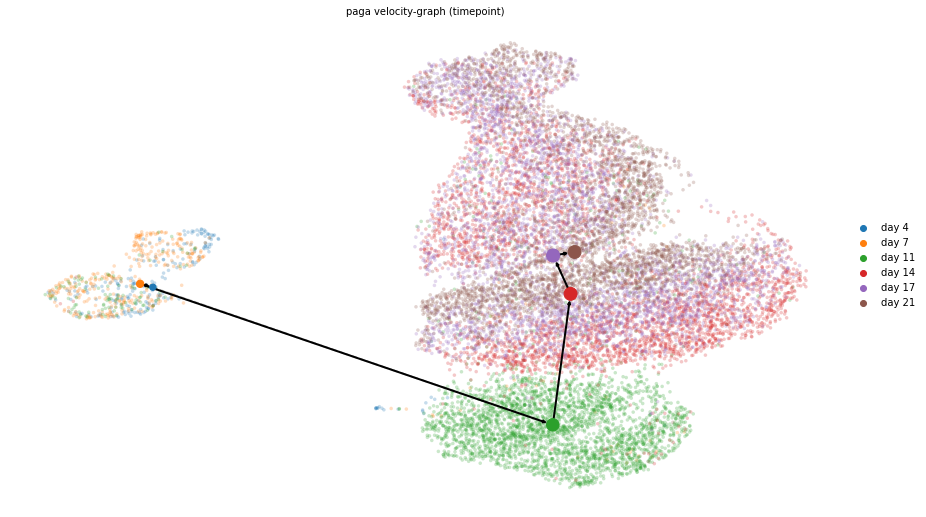

In [116]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.25,
            min_edge_width=2, node_size_scale=1, arrowsize = 5, figsize = (15,9), save = 'scv_paga_umap_transitions.pdf')

saving figure to file ./figures/scvelo_scv_paga_transitions.pdf


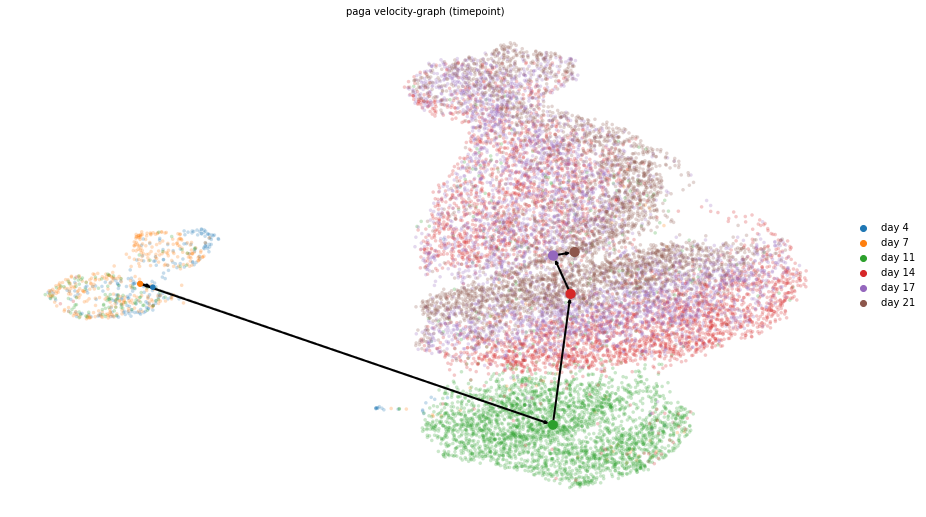

In [109]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.25,
            min_edge_width=2, node_size_scale=0.5, arrowsize = 5, figsize = (15,9), max_edge_width = 20, save = 'scv_paga_transitions.pdf')

# Top-Likelihood Genes

Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model.

In [ ]:
genes = ['Tmed11', 'Adam20','Olfr123', 'Rsl24d1']

In [ ]:
top_genes

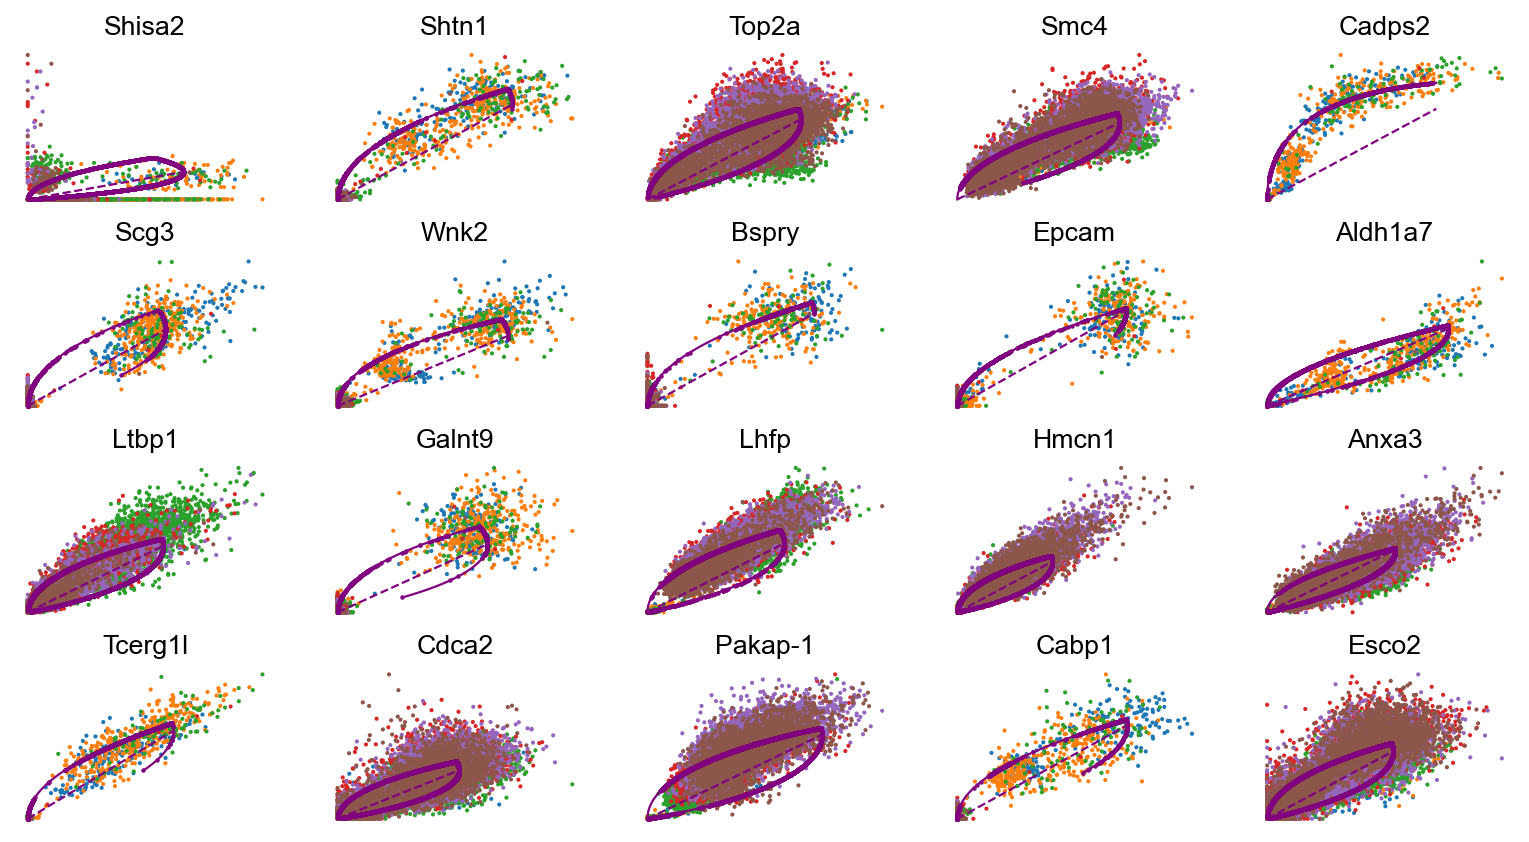

In [142]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:20], ncols=5, frameon=False, color = 'timepoint')

In [137]:
mycgenes = ['Srsf2', 'G3bp1', 'Snrpd1', 'Pgk1', 'Rps3', 'Psmd1', 'Orc2', 'Psma2', 'Syncrip', 'Cnbp',
            'Gspt1', 'Ppm1g', 'Eif4e', 'Hnrnpa3', 'Abce1', 'Hnrnpu',  'Ifrd1', 'Kpna2', 'Dhx15', 'Mcm4']

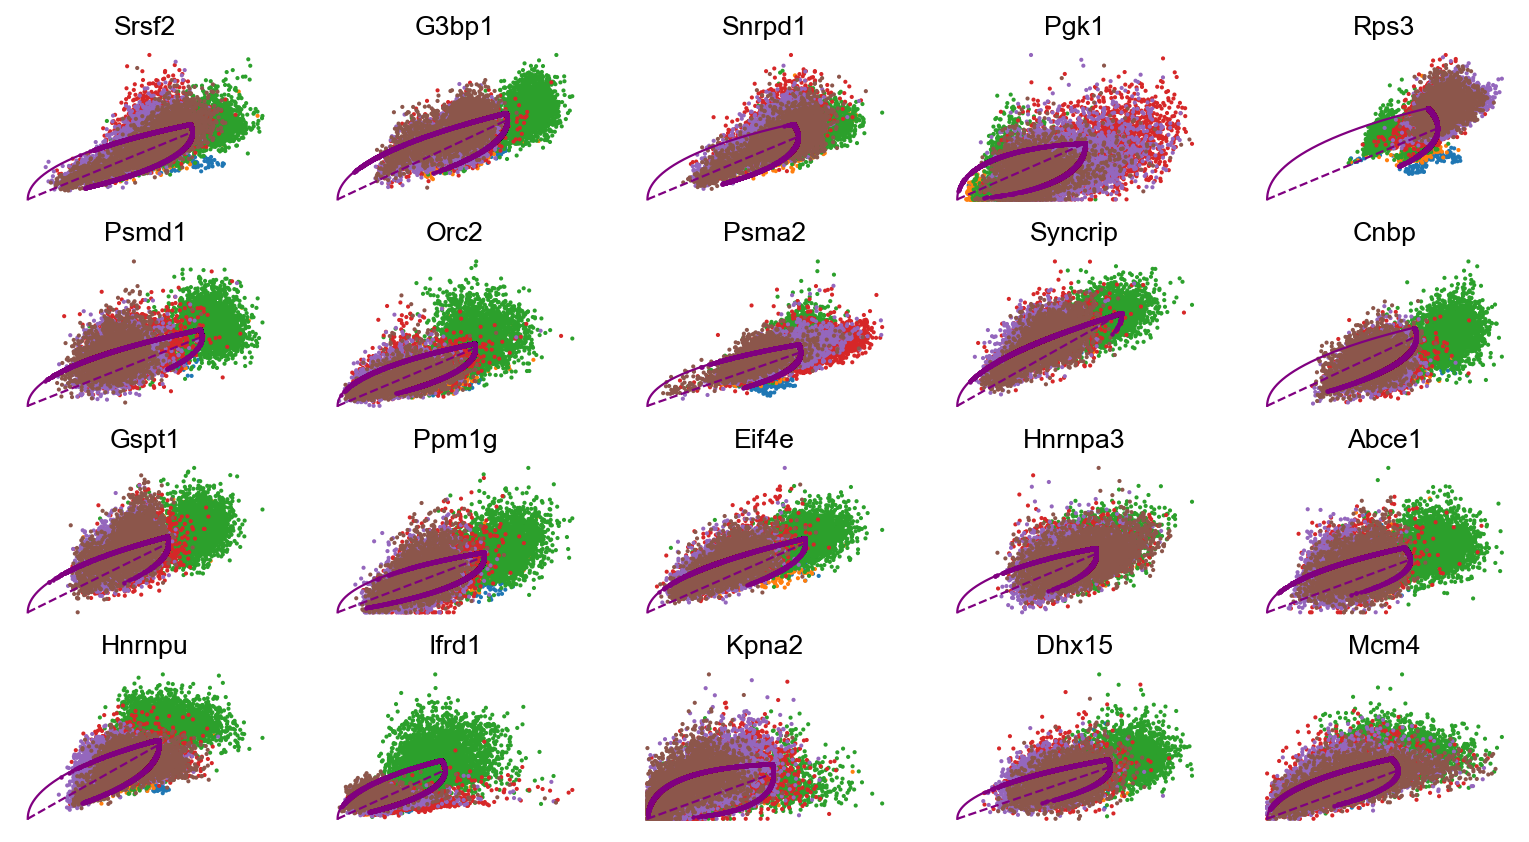

In [141]:
scv.pl.scatter(adata, basis=mycgenes, ncols=5, frameon=False, color = 'timepoint')

In [ ]:
genes = ['Tmed11', 'Adam20','Olfr123', 'Rsl24d1']
var_names = ['Shtn1', 'Top2a', 'Smc4', 'Wnk2'] #took first 4 from top_genes above

In [132]:
NE = ['Chga', 'Ascl1', 'Syp', 'Uchl1', 'Dll3', 'Insm1', 'Nkx2-1','Epcam', 'Neurod1']

In [22]:
EMT = ['Twist2', 'Vim', 'Tgfb2', 'Snai1', ' Twist1', 'Snai2', 'Tgfbr2', 'Zeb1']

In [23]:
Notch = ['Dll4', 'Dll3', 'Hes6', 'Hes1', 'Rest', 'Notch2', 'Jag2', 'Rbpj', 'Myc']

In [24]:
Hippo = ['Cy6r1', 'Tead2', 'Ajuba' , 'Wwtr1', 'Yap1', 'Tead3', 'Ctgf']

In [ ]:
NEnew = [ 'Dll3', 'Nkx2-1', 'MYC']


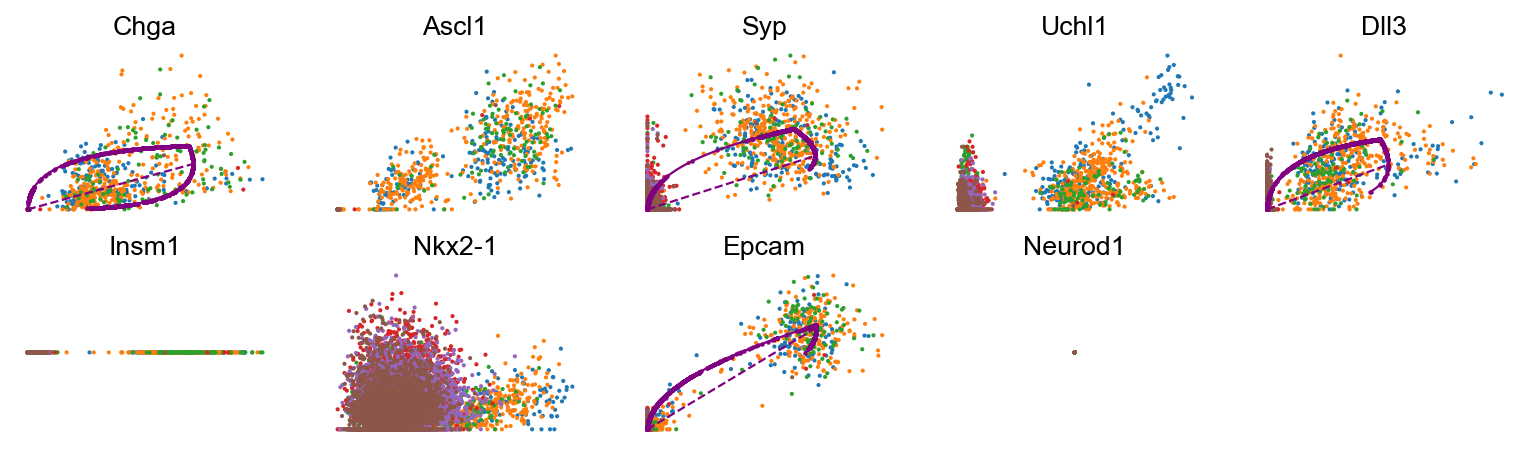

In [133]:
scv.pl.scatter(adata, basis=NE, ncols=5, frameon=False, color = 'timepoint')

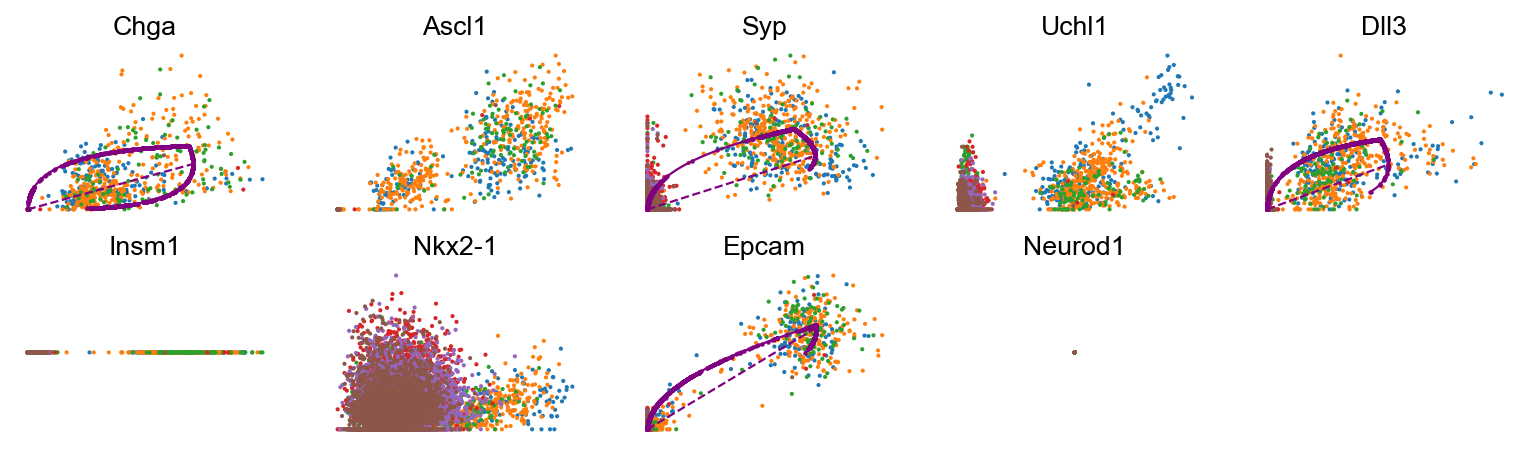

In [21]:
# var_names = ['ASCL1', 'NEURDO1', 'YAP1', 'POU2F3']
# scv.pl.scatter(adata, NEnew, frameon=False, color = 'timepoint')
scv.pl.scatter(adata, basis=NE, ncols=5, frameon=False, color = 'timepoint')

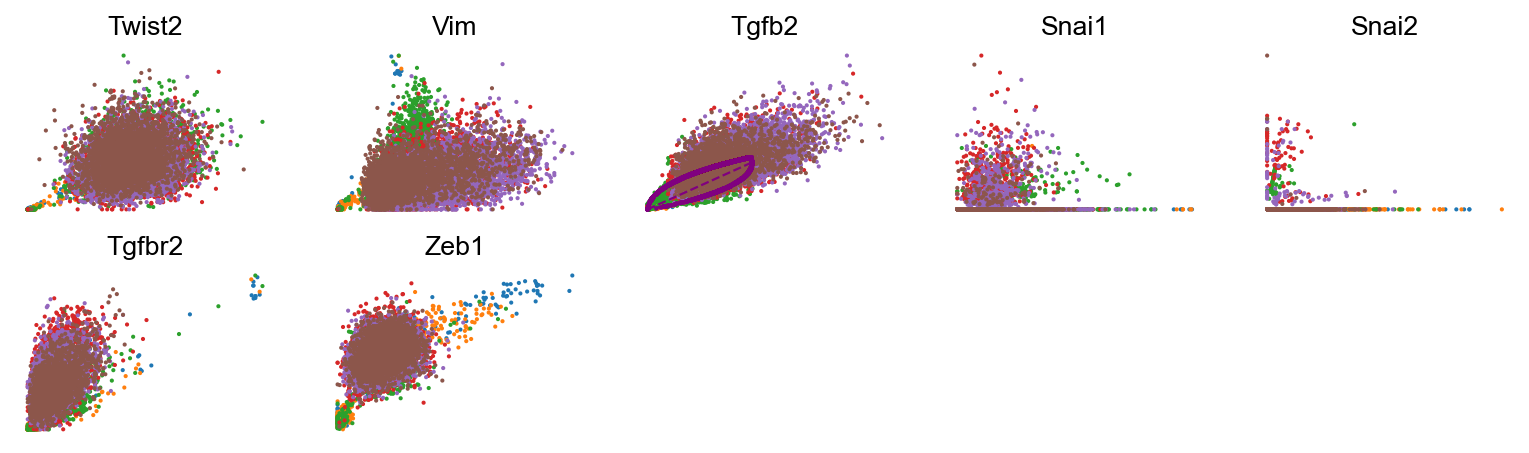

In [25]:
scv.pl.scatter(adata, basis=EMT, ncols=5, frameon=False, color = 'timepoint')

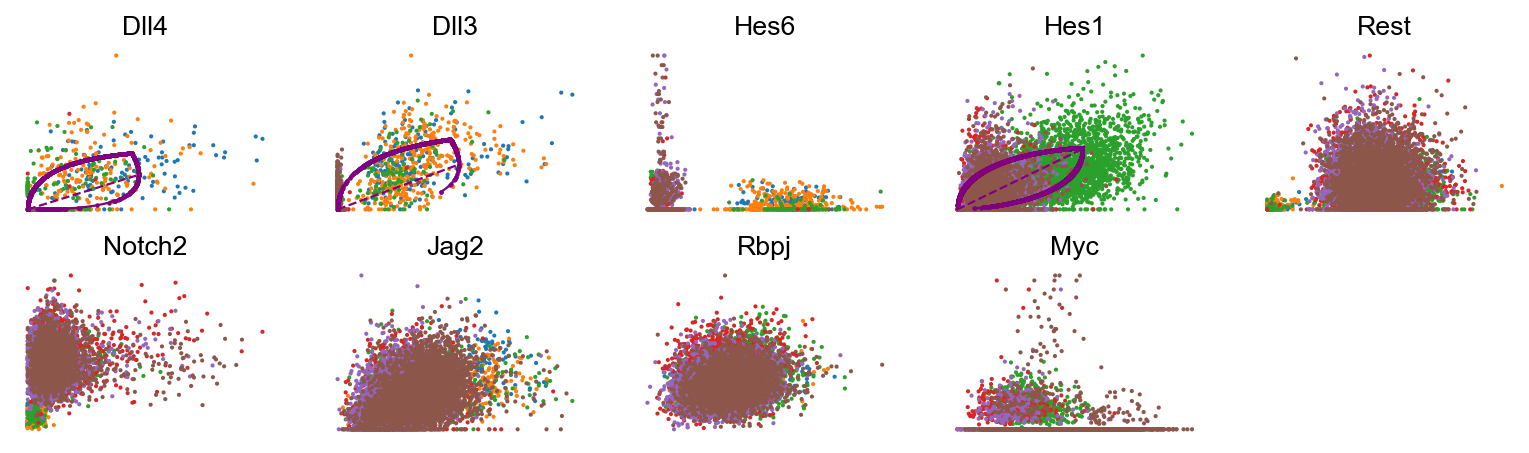

In [26]:
# Notch = ['Dll4', 'Dll3', 'Hes6', 'Hes1', 'Rest', 'Notch2', 'Jag2', 'Rbpj', 'Myc']
scv.pl.scatter(adata, basis=Notch, ncols=5, frameon=False, color = 'timepoint')

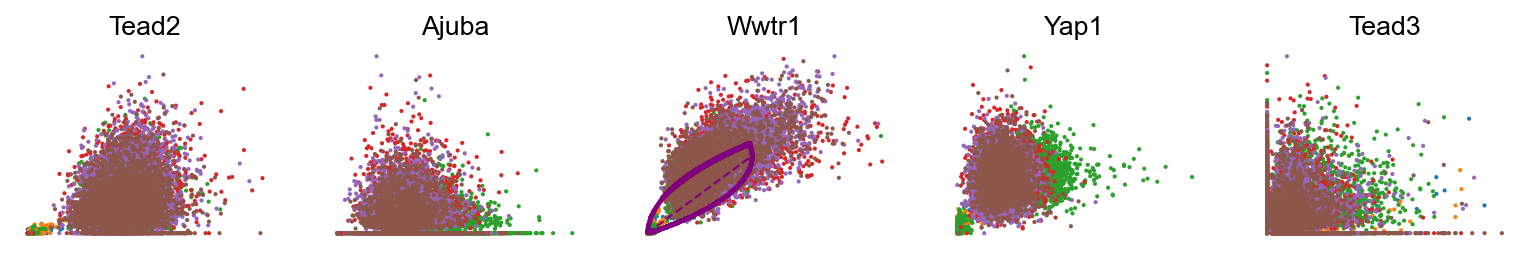

In [27]:
scv.pl.scatter(adata, basis=Hippo, ncols=5, frameon=False, color = 'timepoint')

In [37]:
myc = ['Myc', 'Mycl', 'Mycn']

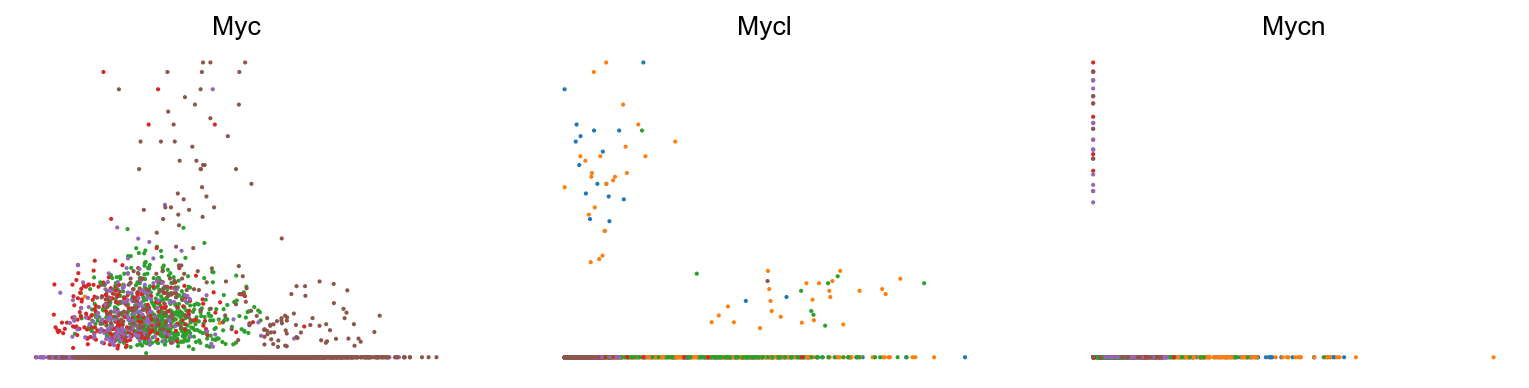

In [40]:
scv.pl.scatter(adata, basis=myc, ncols=5, frameon=False, color = 'timepoint')

In [41]:
Notchs = ['Notch1', 'Notch2', 'Notch3', 'Notch4']

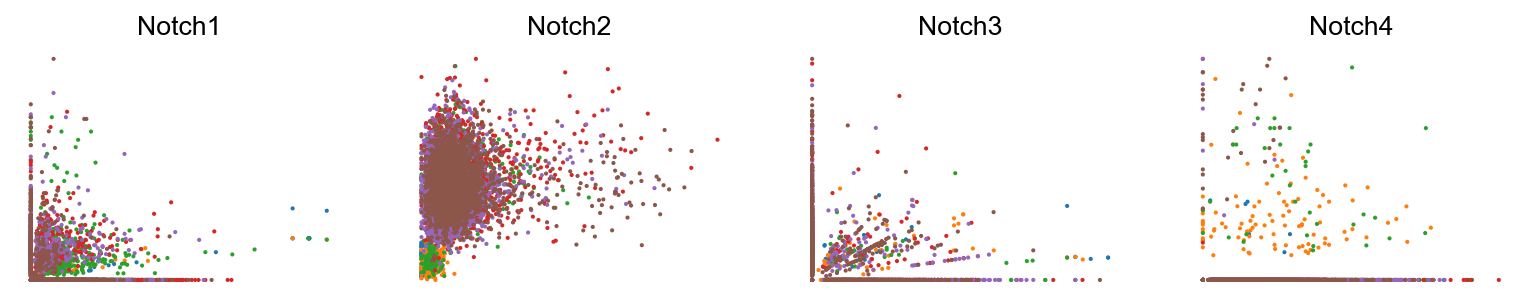

In [42]:
scv.pl.scatter(adata, basis=Notchs, ncols=5, frameon=False, color = 'timepoint')

In [ ]:
var_names = ['Shtn1', 'Top2a', 'Smc4', 'Wnk2'] #took first 4 from top_genes above
# var_names = ['ASCL1', 'NEURDO1', 'YAP1', 'POU2F3']
scv.pl.scatter(adata, var_names, frameon=False, color = 'timepoint')
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False, color = 'timepoint')

In [ ]:
# sc.pp.scale(adata)
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','timepoint'])

Dimensionality Reduction and RNA Velocity

In [ ]:
import matplotlib.pyplot as plt
# sc.pp.neighbors(adata)
# sc.tl.leiden(adata)
# sc.tl.umap(adata, random_state = 1)
sc.pl.umap(adata04, color = ['timepoint','leiden','Ascl1','Myc','Epcam','Hes1'], ncols = 3)